In [65]:
import pandas as pd
df = pd.read_csv('셀트리온.csv')
df.head()

,날짜,종가,전일비,시가,고가,저가,거래량
0,2022-04-19,160500,4000,156500,161000,156500,267752
1,2022-04-18,156500,2000,157000,159000,155500,274233
2,2022-04-15,158500,5500,161500,162000,157500,444152
3,2022-04-14,164000,500,164000,164500,161000,358845
4,2022-04-13,164500,3500,161000,164500,161000,236840


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4143 entries, 0 to 4142
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   날짜      4143 non-null   object
 1   종가      4143 non-null   int64 
 2   전일비     4143 non-null   int64 
 3   시가      4143 non-null   int64 
 4   고가      4143 non-null   int64 
 5   저가      4143 non-null   int64 
 6   거래량     4143 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 226.7+ KB


In [67]:
df['날짜'] = pd.to_datetime(df['날짜'], format='%Y-%m-%d')
df['연도'] = df['날짜'].dt.year

In [68]:
df.head()

,날짜,종가,전일비,시가,고가,저가,거래량,연도
0,2022-04-19,160500,4000,156500,161000,156500,267752,2022
1,2022-04-18,156500,2000,157000,159000,155500,274233,2022
2,2022-04-15,158500,5500,161500,162000,157500,444152,2022
3,2022-04-14,164000,500,164000,164500,161000,358845,2022
4,2022-04-13,164500,3500,161000,164500,161000,236840,2022


In [69]:
df.rename(columns = {'날짜' : '일자'}, inplace=True)
df.head()

,일자,종가,전일비,시가,고가,저가,거래량,연도
0,2022-04-19,160500,4000,156500,161000,156500,267752,2022
1,2022-04-18,156500,2000,157000,159000,155500,274233,2022
2,2022-04-15,158500,5500,161500,162000,157500,444152,2022
3,2022-04-14,164000,500,164000,164500,161000,358845,2022
4,2022-04-13,164500,3500,161000,164500,161000,236840,2022


Text(0, 0.5, 'price')

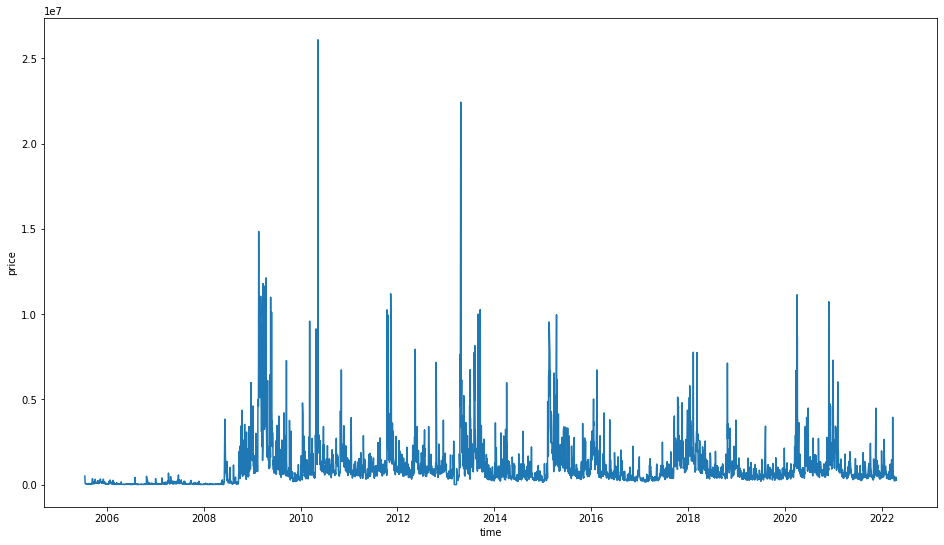

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16,9))
sns.lineplot(y=df['거래량'], x=df['일자'])
plt.xlabel('time')
plt.ylabel('price')

Text(0, 0.5, 'price')

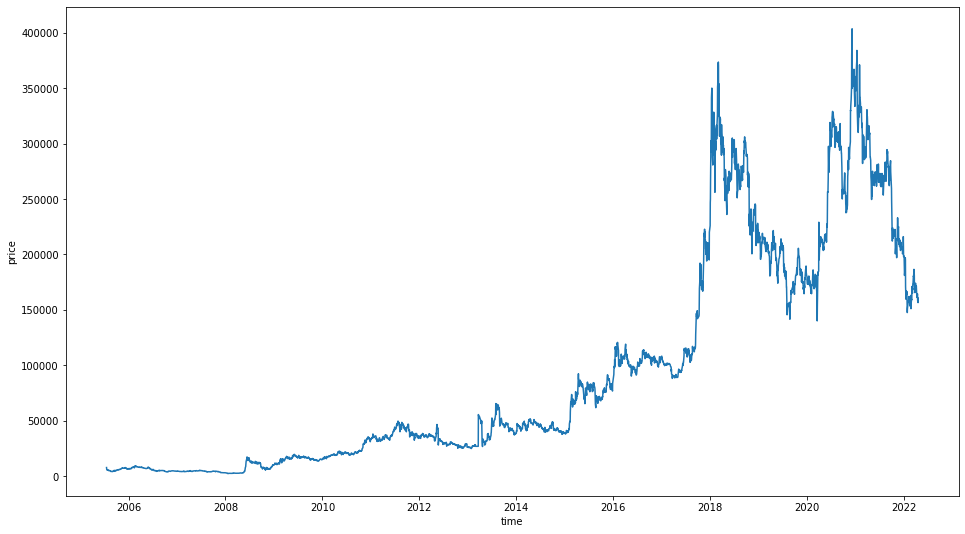

In [71]:
plt.figure(figsize=(16,9))
sns.lineplot(y=df['종가'], x=df['일자'])
plt.xlabel('time')
plt.ylabel('price')

In [72]:
from sklearn.preprocessing import MinMaxScaler
df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols
df_scaled.head()

,시가,고가,저가,종가,거래량
0,0.394704,0.399009,0.411842,0.394362,0.010265
1,0.395965,0.394052,0.409211,0.384393,0.010514
2,0.407314,0.401487,0.414474,0.389378,0.017028
3,0.413619,0.407683,0.423684,0.403086,0.013758
4,0.406053,0.407683,0.423684,0.404332,0.009080


In [73]:
TEST_SIZE = 200
WINDOW_SIZE = 20

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [74]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [75]:
from sklearn.model_selection import train_test_split
import numpy as np
feature_cols = ['시가', '고가', '저가', '거래량']
label_cols = ['종가']
train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

X_train, X_valid, y_train, y_valid = train_test_split(
    train_feature, train_label, test_size = 0.2
)

X_train.shape, X_valid.shape


((3138, 20, 4), (785, 20, 4))

In [76]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((200, 4), (200, 1))

In [77]:

test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((180, 20, 4), (180, 1))

In [78]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))


In [79]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(X_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(X_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
197/197 [==============================] - ETA: 0s - loss: 0.0045
Epoch 1: val_loss improved from inf to 0.00045, saving model to model/tmp_checkpoint.h5
197/197 [==============================] - 3s 9ms/step - loss: 0.0045 - val_loss: 4.5312e-04
Epoch 2/200
192/197 [============================>.] - ETA: 0s - loss: 4.1853e-04
Epoch 2: val_loss improved from 0.00045 to 0.00034, saving model to model/tmp_checkpoint.h5
197/197 [==============================] - 2s 9ms/step - loss: 4.1736e-04 - val_loss: 3.4299e-04
Epoch 3/200
196/197 [============================>.] - ETA: 0s - loss: 3.3479e-04
Epoch 3: val_loss improved from 0.00034 to 0.00031, saving model to model/tmp_checkpoint.h5
197/197 [==============================] - 3s 14ms/step - loss: 3.3462e-04 - val_loss: 3.1238e-04
Epoch 4/200
195/197 [============================>.] - ETA: 0s - loss: 2.9710e-04
Epoch 4: val_loss improved from 0.00031 to 0.00030, saving model to model/tmp_checkpoint.h5
197/197 [===============

In [80]:
model.load_weights(filename)
pred = model.predict(test_feature)


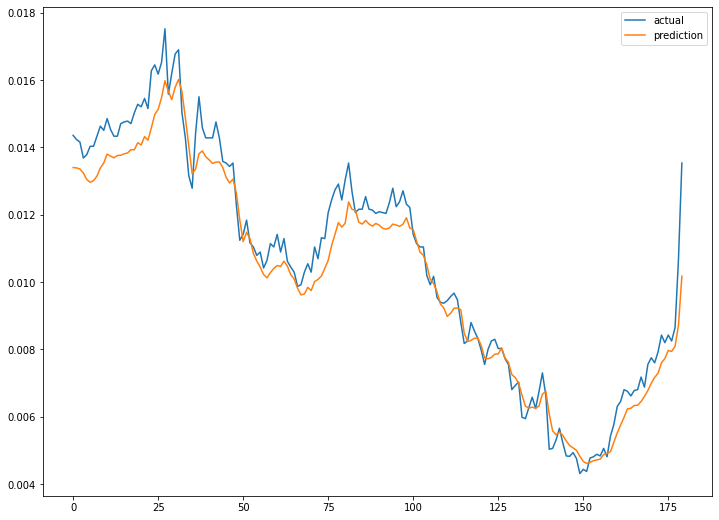

In [81]:
pred.shape
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

In [82]:
from sklearn.preprocessing import MinMaxScaler
df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols
df_scaled.head()
TEST_SIZE = 200
WINDOW_SIZE = 20

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)
from sklearn.model_selection import train_test_split
import numpy as np
feature_cols = ['시가', '고가', '저가', '거래량']
label_cols = ['종가']
train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

X_train, X_valid, y_train, y_valid = train_test_split(
    train_feature, train_label, test_size = 0.2
)

X_train.shape, X_valid.shape
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(X_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(X_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()


Epoch 1/200
151/197 [=====================>........] - ETA: 0s - loss: 0.0178

KeyboardInterrupt: ignored

In [112]:
df2 = df.copy()
df2

,일자,종가,전일비,시가,고가,저가,거래량,연도
0,2022-04-19,160500,4000,156500,161000,156500,267752,2022
1,2022-04-18,156500,2000,157000,159000,155500,274233,2022
2,2022-04-15,158500,5500,161500,162000,157500,444152,2022
3,2022-04-14,164000,500,164000,164500,161000,358845,2022
4,2022-04-13,164500,3500,161000,164500,161000,236840,2022
...,...,...,...,...,...,...,...,...
4138,2005-07-25,5650,70,5500,5950,5500,61036,2005
4139,2005-07-22,5580,160,5850,5850,5530,69921,2005
4140,2005-07-21,5740,810,6450,6580,5730,182685,2005
4141,2005-07-20,6550,1150,7690,7690,6550,422688,2005


In [115]:
df2['월'] = df['일자'].dt.month
df2['일'] = df['일자'].dt.day
df2.head()

,일자,종가,전일비,시가,고가,저가,거래량,연도,월,일
0,2022-04-19,160500,4000,156500,161000,156500,267752,2022,4,19
1,2022-04-18,156500,2000,157000,159000,155500,274233,2022,4,18
2,2022-04-15,158500,5500,161500,162000,157500,444152,2022,4,15
3,2022-04-14,164000,500,164000,164500,161000,358845,2022,4,14
4,2022-04-13,164500,3500,161000,164500,161000,236840,2022,4,13


In [116]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4143 entries, 0 to 4142
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   일자      4143 non-null   datetime64[ns]
 1   종가      4143 non-null   int64         
 2   전일비     4143 non-null   int64         
 3   시가      4143 non-null   int64         
 4   고가      4143 non-null   int64         
 5   저가      4143 non-null   int64         
 6   거래량     4143 non-null   int64         
 7   연도      4143 non-null   int64         
 8   월       4143 non-null   int64         
 9   일       4143 non-null   int64         
dtypes: datetime64[ns](1), int64(9)
memory usage: 323.8 KB


In [129]:
df2 = df2.sort_values('일자')
df2 = df2.reset_index(drop=True)
df2.head()

,일자,종가,전일비,시가,고가,저가,거래량,연도,월,일
0,2005-07-19,7700,2500,6700,7700,6510,499088,2005,7,19
1,2005-07-20,6550,1150,7690,7690,6550,422688,2005,7,20
2,2005-07-21,5740,810,6450,6580,5730,182685,2005,7,21
3,2005-07-22,5580,160,5850,5850,5530,69921,2005,7,22
4,2005-07-25,5650,70,5500,5950,5500,61036,2005,7,25


In [133]:
df2['index'] = df2.index.to_list()
df2.head()

,일자,종가,전일비,시가,고가,저가,거래량,연도,월,일,index
0,2005-07-19,7700,2500,6700,7700,6510,499088,2005,7,19,0
1,2005-07-20,6550,1150,7690,7690,6550,422688,2005,7,20,1
2,2005-07-21,5740,810,6450,6580,5730,182685,2005,7,21,2
3,2005-07-22,5580,160,5850,5850,5530,69921,2005,7,22,3
4,2005-07-25,5650,70,5500,5950,5500,61036,2005,7,25,4


Epoch 1/200
194/197 [============================>.] - ETA: 0s - loss: 15806599168.0000
Epoch 1: val_loss improved from inf to 8766515200.00000, saving model to model/tmp_checkpoint.h5
197/197 [==============================] - 3s 9ms/step - loss: 15858098176.0000 - val_loss: 8766515200.0000
Epoch 2/200
191/197 [============================>.] - ETA: 0s - loss: 16577750016.0000
Epoch 2: val_loss did not improve from 8766515200.00000
197/197 [==============================] - 2s 8ms/step - loss: 16634982400.0000 - val_loss: 15635609600.0000
Epoch 3/200
191/197 [============================>.] - ETA: 0s - loss: 16668462080.0000
Epoch 3: val_loss did not improve from 8766515200.00000
197/197 [==============================] - 2s 8ms/step - loss: 16789348352.0000 - val_loss: 15536839680.0000
Epoch 4/200
197/197 [==============================] - ETA: 0s - loss: 16702367744.0000
Epoch 4: val_loss did not improve from 8766515200.00000
197/197 [==============================] - 2s 8ms/step - 

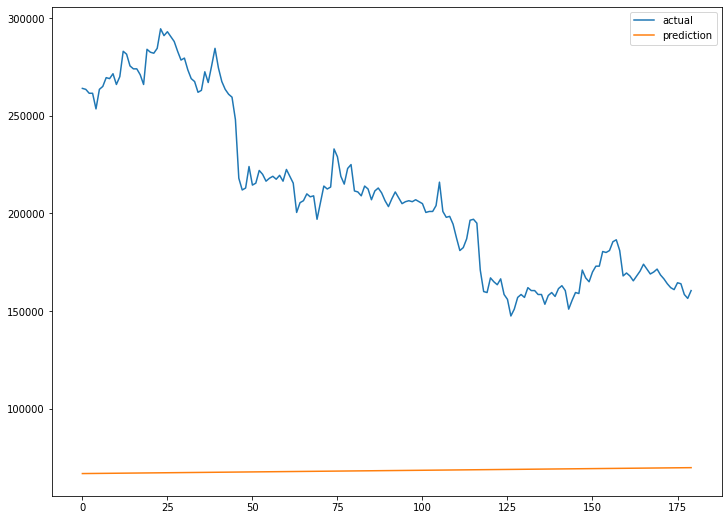

In [134]:

TEST_SIZE = 200
WINDOW_SIZE = 20

train = df2[:-TEST_SIZE]
test = df2[-TEST_SIZE:]

def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)


from sklearn.model_selection import train_test_split
import numpy as np


feature_cols = ['index']
label_cols = ['종가']
train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

X_train, X_valid, y_train, y_valid = train_test_split(
    train_feature, train_label, test_size = 0.2
)

X_train.shape, X_valid.shape
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(X_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(X_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()
